# LGBM을 활용한 베이스라인

In [32]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [34]:
data_dir = '/opt/ml/input/data' # 경로는 상황에 맞춰서 수정해주세요!
csv_file_path = os.path.join(data_dir, 'train_data.csv') # 데이터는 대회홈페이지에서 받아주세요 :)
df = pd.read_csv(csv_file_path) 

In [51]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 2. Feature Engineering

In [68]:
def feature_engineering(df):
    
    #유저별 시퀀스를 고려하기 위해 아래와 같이 정렬
    df.sort_values(by=['userID','Timestamp'], inplace=True)
    
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_correct_answer'] = df.groupby('userID')['answerCode'].transform(lambda x: x.cumsum().shift(1))
    df['user_total_answer'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_correct_answer']/df['user_total_answer']

    # testId와 KnowledgeTag의 전체 정답률은 한번에 계산
    # 아래 데이터는 제출용 데이터셋에 대해서도 재사용
    correct_t = df.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
    correct_t.columns = ["test_mean", 'test_sum']
    correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
    correct_k.columns = ["tag_mean", 'tag_sum']

    df = pd.merge(df, correct_t, on=['testId'], how="left")
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")

    df.sort_values(by=['userID','Timestamp'], inplace=True)

    
    return df

    # def feature_engineering(df):
    # # 유저 별 시퀀스를 고려하기 위해 아래와 같이 정렬(오름차순)
    # df.sort_values(by=['userID', 'Timestamp'], inplace=True) # 정렬할 기준 변수, DataFrame 자체를 정렬해서 저장
    # return df

In [32]:
correct_k = df.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
correct_k.columns = ["tag_mean", 'tag_sum']
correct_k = correct_k['tag_mean']
dff = df
dff = pd.merge(dff, correct_k, on=['KnowledgeTag'], how="left")
dff.head(5)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,tag_mean
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.955022
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.913187
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.913187
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.913187
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.913187


In [68]:
def subjective_fe(df):
    import datetime
    import numpy as np
# timestamp 숫자로 변경
    a = df['Timestamp'].to_list()
    b = []
    for row in a:
        date_time_obj = datetime.datetime.strptime(row, '%Y-%m-%d %H:%M:%S')
        b.append(int(date_time_obj.timestamp()))
    df['Timestamp'] = b
    del a,b
    df = df.fillna(0)
    df = df.sort_values(['userID','Timestamp'])
    temp = df
    a = temp.groupby('userID')['Timestamp'].diff().fillna(0)
    temp['Timestamp'] = a
    df = temp
    del temp
    df['Timestamp'] = df.groupby('userID')['Timestamp'].cumsum()
    df['Timestamp'] = df['Timestamp'].astype(np.int32)

    #log1 -> timestamp
    # log1p_cols = ['Timestamp']
    # df[log1p_cols] = np.log1p(df[log1p_cols])

    #big-class
    testId_ll = df['testId'].values
    # 시험지 대 분류 원소로 가짐 ex) 6
    big_ll = []
    for i,id in enumerate(testId_ll):
        big_ll.append(int(id[2]))
    df['big_class'] = big_ll

    #TimeClass
    a = df.groupby('userID')['Timestamp']
    tclassidx = []
    for i in a:
        wholetime = i[1].values[-1] - i[1].values[0]
        term = int(wholetime/10)
        for j in i[1].values:
            if(j/term >= 10):
                tclassidx.append(9)
            else:
                tclassidx.append(int(j/term))
    df['TimeClass'] = tclassidx
    
    return df


> #시간을 맨끝에서부터 세는건 어떨까??
>> ##eda 인사이트 넣어서 classification 해보는건???

In [69]:
df = feature_engineering(df)
# df = subjective_fe(df)

df.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean_x,...,tag_mean_x,tag_sum_x,test_mean_y,test_sum_y,tag_mean_y,tag_sum_y,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,...,0.955022,637,0.947683,1268,0.955022,637,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.0,0.947683,...,0.913187,3040,0.947683,1268,0.913187,3040,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.0,0.947683,...,0.913187,3040,0.947683,1268,0.913187,3040,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.0,0.947683,...,0.913187,3040,0.947683,1268,0.913187,3040,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.0,0.947683,...,0.913187,3040,0.947683,1268,0.913187,3040,0.947683,1268,0.913187,3040


> a<sup>민지</sup>

> # timestamp 숫자로 해볼까?

In [11]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.947683,1268,0.913187,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,1.0,4,0.250000,0.662590,921,0.689706,2814
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1.0,5,0.200000,0.655109,718,0.697874,2199
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2.0,6,0.333333,0.655109,718,0.697874,2199
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3.0,7,0.428571,0.655109,718,0.697874,2199


> # 개인적인 FE


In [7]:
df[df['userID']==0]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,NaN,0,NaN,0.947683,1268,0.955022,637
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,1.0,1,1.000000,0.947683,1268,0.913187,3040
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,2.0,2,1.000000,0.947683,1268,0.913187,3040
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,3.0,3,1.000000,0.947683,1268,0.913187,3040
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,4.0,4,1.000000,0.947683,1268,0.913187,3040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
740,0,A080129002,A080000129,1,2020-12-23 03:35:54,2723,468.0,740,0.632432,0.360111,780,0.476454,344
741,0,A080129003,A080000129,0,2020-12-23 03:37:20,2725,469.0,741,0.632928,0.360111,780,0.301939,436
742,0,A080129004,A080000129,1,2020-12-23 03:38:43,2725,469.0,742,0.632075,0.360111,780,0.301939,436
743,0,A080129005,A080000129,0,2020-12-23 03:40:14,2725,470.0,743,0.632571,0.360111,780,0.301939,436


## 3. Train/Test 데이터 셋 분리

In [71]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.8, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

## K-fold

In [75]:
random.seed(42)
user_list = df['userID'].unique()
cut_line = int(len(user_list)/5)
# 0.8 0.2 = 4 1
# print(user_list[0])
random.shuffle(user_list)
# print(user_list[0])

# K-5
set_ll = []
set1 = user_list[:cut_line]
set2 = user_list[cut_line:cut_line*2]
set3 = user_list[cut_line*2:cut_line*3]
set4 = user_list[cut_line*3:cut_line*4]
set5 = user_list[cut_line*4:]

set_ll.append(set1)
set_ll.append(set2)
set_ll.append(set3)
set_ll.append(set4)
set_ll.append(set5)

set_ll
# print(len(set1))
# print(len(set5))









[array([1993,  247, 5506, ...,  601, 1514, 4757]),
 array([2354, 3028,  932, ..., 4422, 1630, 4321]),
 array([7291,  265, 1282, ..., 5025, 1639, 5639]),
 array([6857, 2132, 7115, ..., 2301, 5655, 6803]),
 array([5795, 2007, 3214, ...,  225, 1023, 5820])]

In [30]:
np.mean([3,4])

3.5

In [76]:
FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
         'user_acc','test_mean', 'tag_mean',]
accs, aucs = [],[]


for k in range(5):
    print(k,'th start!!')
    for_train_users = []
    for_val_users = set_ll[k]
    for j in range(5):
        if(j != k):
            for_train_users.extend(set_ll[j])
    train = df[df['userID'].isin(for_train_users)]
    test = df[df['userID'].isin(for_train_users) == False]
    test = test[test['userID'] != test['userID'].shift(-1)]

    y_train = train['answerCode']
    train = train.drop(['answerCode'], axis=1)

    y_test = test['answerCode']
    test = test.drop(['answerCode'], axis=1)

    lgb_train = lgb.Dataset(train[FEATS], y_train)
    lgb_test = lgb.Dataset(test[FEATS], y_test)

    model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=10000,
    early_stopping_rounds=1000
    )

    preds = model.predict(test[FEATS])
    acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
    auc = roc_auc_score(y_test, preds)
    accs.append(float(acc))
    aucs.append(float(auc))

    print(f'VALID AUC : {auc} ACC : {acc}\n')

    # LOAD TESTDATA
    test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
    test_df = pd.read_csv(test_csv_file_path)

    # FEATURE ENGINEERING
    test_df = feature_engineering(test_df)
    # test_df = subjective_fe(test_df)

    # LEAVE LAST INTERACTION ONLY
    test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

    # DROP ANSWERCODE
    test_df = test_df.drop(['answerCode'], axis=1)

    total_preds = model.predict(test_df[FEATS])
    
    # SAVE OUTPUT
    output_dir = 'output/kfold/'
    name = 'lgbm-Aprime_longepoch-fold' + str(k) + '.csv'
    write_path = os.path.join(output_dir, name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    with open(write_path, 'w', encoding='utf8') as w:
        print("writing prediction : {}".format(write_path))
        w.write("id,prediction\n")
        for id, p in enumerate(total_preds):
            w.write('{},{}\n'.format(id,p))
    print(k,'th end!!')
    # break
    

# np.mean([3,4])


    

0 th start!!


/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1186229, number of negative: 623249
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1809478, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655564 -> initscore=0.643589
[LightGBM] [Info] Start training from score 0.643589
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.560673	valid_1's binary_logloss: 0.677948
[200]	training's binary_logloss: 0.558218	valid_1's binary_logloss: 0.676081
[300]	training's binary_logloss: 0.556314	valid_1's binary_logloss: 0.674211
[400]	training's binary_logloss: 0.554523	valid_1's binary_logloss: 0.673106
[500]	training's binary_logloss: 0.552897	valid_1's binary_logloss

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1186200, number of negative: 629007
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1815207, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.653479 -> initscore=0.634368
[LightGBM] [Info] Start training from score 0.634368
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.560556	valid_1's binary_logloss: 0.718596
[200]	training's binary_logloss: 0.558072	valid_1's binary_logloss: 0.718638
[300]	training's binary_logloss: 0.556109	valid_1's binary_logloss: 0.717565
[400]	training's binary_logloss: 0.554471	valid_1's binary_logloss: 0.71795
[500]	training's binary_logloss: 0.552884	valid_1's binary_logloss:

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1181611, number of negative: 628286
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.023256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1809897, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.652861 -> initscore=0.631639
[LightGBM] [Info] Start training from score 0.631639
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.562541	valid_1's binary_logloss: 0.683165
[200]	training's binary_logloss: 0.560094	valid_1's binary_logloss: 0.682107
[300]	training's binary_logloss: 0.558183	valid_1's binary_logloss: 0.681664
[400]	training's binary_logloss: 0.556551	valid_1's binary_logloss: 0.682484
[500]	training's binary_logloss: 0.554954	valid_1's binary_logloss

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1188671, number of negative: 628469
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021279 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1817140, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654144 -> initscore=0.637304
[LightGBM] [Info] Start training from score 0.637304
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.560785	valid_1's binary_logloss: 0.679041
[200]	training's binary_logloss: 0.558293	valid_1's binary_logloss: 0.678342
[300]	training's binary_logloss: 0.556257	valid_1's binary_logloss: 0.678931
[400]	training's binary_logloss: 0.554536	valid_1's binary_logloss: 0.679011
[500]	training's binary_logloss: 0.5531	valid_1's binary_logloss: 

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1190109, number of negative: 624513
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020492 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1529
[LightGBM] [Info] Number of data points in the train set: 1814622, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655844 -> initscore=0.644828
[LightGBM] [Info] Start training from score 0.644828
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.56085	valid_1's binary_logloss: 0.676
[200]	training's binary_logloss: 0.558428	valid_1's binary_logloss: 0.675605
[300]	training's binary_logloss: 0.556492	valid_1's binary_logloss: 0.675503
[400]	training's binary_logloss: 0.554685	valid_1's binary_logloss: 0.675514
[500]	training's binary_logloss: 0.553224	valid_1's binary_logloss: 0.

In [77]:
print('mean auc : ', np.mean(aucs))
print('mean acc : ', np.mean(accs))


mean auc :  0.694040766580001
mean acc :  0.5985339505314041


In [72]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정

FEATS = ['user_acc','test_mean']


# FEATS = ['KnowledgeTag', 'user_correct_answer', 'user_total_answer', 
#          'user_acc','big_class', 'TimeClass 'test_mean', 'test_sum', 'tag_mean','tag_sum','Timestamp']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [40]:
y_train
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
745,1,A040013001,A040000013,0.000000,2048,0.0,0,0.000000,0.595472,789,0.616900,971
746,1,A040013002,A040000013,5.214936,2048,1.0,1,1.000000,0.595472,789,0.616900,971
747,1,A040013003,A040000013,5.424950,2047,2.0,2,1.000000,0.595472,789,0.570962,1050
748,1,A040013004,A040000013,5.802118,2047,3.0,3,1.000000,0.595472,789,0.570962,1050
749,1,A040013005,A040000013,6.297109,2047,4.0,4,1.000000,0.595472,789,0.570962,1050
...,...,...,...,...,...,...,...,...,...,...,...,...
2266572,7440,A030197001,A030000197,15.512239,1984,5.0,10,0.500000,0.738462,1008,0.749632,2039
2266573,7440,A030197002,A030000197,15.512250,1984,6.0,11,0.545455,0.738462,1008,0.749632,2039
2266574,7440,A030197003,A030000197,15.512255,1984,6.0,12,0.500000,0.738462,1008,0.749632,2039
2266575,7440,A030197004,A030000197,15.512256,1984,6.0,13,0.461538,0.738462,1008,0.749632,2039


In [5]:
!pip install lightgbm

In [38]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np

In [73]:
lgb_train = lgb.Dataset(train[FEATS], y_train)
lgb_test = lgb.Dataset(test[FEATS], y_test)

## 4. 훈련 및 검증

In [74]:
model = lgb.train(
    {'objective': 'binary'}, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=10000,
    early_stopping_rounds=1000
)

preds = model.predict(test[FEATS])
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.8/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1187785, number of negative: 624671
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 1812456, number of used features: 2
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655346 -> initscore=0.642620
[LightGBM] [Info] Start training from score 0.642620
Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.565756	valid_1's binary_logloss: 0.682997
[200]	training's binary_logloss: 0.565178	valid_1's binary_logloss: 0.682763
[300]	training's binary_logloss: 0.56459	valid_1's binary_logloss: 0.682804
[400]	training's binary_logloss: 0.564104	valid_1's binary_logloss: 0.682901
[500]	training's binary_logloss: 0.56362	valid_1's binary_logloss: 0.683297
[600]	training's binary_logloss: 0.56318	valid_1's binar

In [13]:
len(preds)

2007

In [12]:
# !pip install matplotlib
import matplotlib

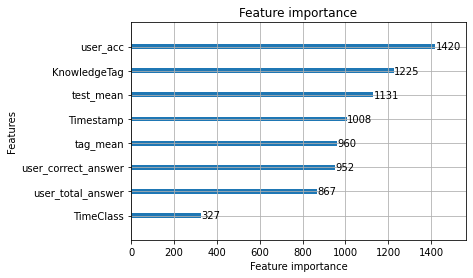

In [83]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

># RFECV 예제

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier

In [25]:
train

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
745,1,1538,1,0.000000,2048,0.0,0,0.000000,0.595472,789,0.616900,971
746,1,1539,1,5.214936,2048,1.0,1,1.000000,0.595472,789,0.616900,971
747,1,1540,1,5.424950,2047,2.0,2,1.000000,0.595472,789,0.570962,1050
748,1,1541,1,5.802118,2047,3.0,3,1.000000,0.595472,789,0.570962,1050
749,1,1542,1,6.297109,2047,4.0,4,1.000000,0.595472,789,0.570962,1050
...,...,...,...,...,...,...,...,...,...,...,...,...
2266572,7440,9779,1335,15.512239,1984,5.0,10,0.500000,0.738462,1008,0.749632,2039
2266573,7440,9780,1335,15.512250,1984,6.0,11,0.545455,0.738462,1008,0.749632,2039
2266574,7440,9781,1335,15.512255,1984,6.0,12,0.500000,0.738462,1008,0.749632,2039
2266575,7440,9782,1335,15.512256,1984,6.0,13,0.461538,0.738462,1008,0.749632,2039


In [13]:
cate2id_dict = {}

# 0은 nan이 사용한다
offset = 1

# bigclass2id
# bigclass2id = dict([(v, i+offset) for i, v in enumerate(df['big_class'].unique())])
# cate2id_dict['bigclass2id'] = bigclass2id
# offset += len(bigclass2id)

# KnowledgeTag
# lec_content2id
# KnowledgeTag2id = dict([(v, i+offset) for i, v in enumerate(train_df['KnowledgeTag'].unique())])
# cate2id_dict['KnowledgeTag2id'] = KnowledgeTag2id
# offset += len(KnowledgeTag2id)

# testId 
# tags2id
testId2id = dict([(v, i+offset) for i, v in enumerate(train['testId'].unique())])
cate2id_dict['testId2id'] = testId2id
offset += len(testId2id)

# assessmentItemID
# part2id
assessment2id = dict([(v, i+offset) for i, v in enumerate(train['assessmentItemID'].unique())])
cate2id_dict['assessment2id'] = assessment2id
offset += len(assessment2id)

train['testId'] = train['testId'].map(testId2id)
train['assessmentItemID'] = train['assessmentItemID'].map(assessment2id)

train.head(5)



,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
745,1,1538,1,0.000000,2048,0.0,0,0.0,0.595472,789,0.616900,971
746,1,1539,1,5.214936,2048,1.0,1,1.0,0.595472,789,0.616900,971
747,1,1540,1,5.424950,2047,2.0,2,1.0,0.595472,789,0.570962,1050
748,1,1541,1,5.802118,2047,3.0,3,1.0,0.595472,789,0.570962,1050
749,1,1542,1,6.297109,2047,4.0,4,1.0,0.595472,789,0.570962,1050


In [16]:
# y_train
X_ll = train.values.tolist()
X_ll[:2]

[[1.0,
  1538.0,
  1.0,
  0.0,
  2048.0,
  0.0,
  0.0,
  0.0,
  0.5954716981132075,
  789.0,
  0.6168996188055909,
  971.0],
 [1.0,
  1539.0,
  1.0,
  5.214935757608986,
  2048.0,
  1.0,
  1.0,
  1.0,
  0.5954716981132075,
  789.0,
  0.6168996188055909,
  971.0]]

In [51]:
len(X_ll[0])

12

In [17]:
y_ll = y_train.values.tolist()
# y_ll

In [45]:
from sklearn.datasets import make_friedman1
X, y = make_friedman1(n_samples=50, n_features=10, random_state=0)
len(X)
X[0]

array([0.5488135 , 0.71518937, 0.60276338, 0.54488318, 0.4236548 ,
       0.64589411, 0.43758721, 0.891773  , 0.96366276, 0.38344152])

In [22]:
# cv = Repeated
from sklearn.svm import SVR
from lightgbm import LGBMClassifier
lgbm_wrapper = LGBMClassifier()

# estimator = model
selector = RFECV(lgbm_wrapper,step=1,cv=4)
selector = selector.fit(X_ll,y_ll)


In [24]:
selector.ranking_

array([ 2,  1, 12,  8,  6, 10,  5,  3,  4,  9,  7, 11])

In [26]:
train.head(3)

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
745,1,1538,1,0.000000,2048,0.0,0,0.0,0.595472,789,0.616900,971
746,1,1539,1,5.214936,2048,1.0,1,1.0,0.595472,789,0.616900,971
747,1,1540,1,5.424950,2047,2.0,2,1.0,0.595472,789,0.570962,1050


In [59]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = feature_engineering(test_df)
# test_df = subjective_fe(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

In [173]:
test_df

,userID,assessmentItemID,testId,Timestamp,KnowledgeTag,user_correct_answer,user_total_answer,user_acc,test_mean,test_sum,tag_mean,tag_sum
1035,3,A050133008,A050000133,25150646,5289,717.0,1035,0.692754,0.661765,90,0.542662,159
1706,4,A070146008,A070000146,27642858,9080,465.0,670,0.694030,0.740385,77,0.565693,155
3023,13,A070111008,A070000111,27902172,9660,915.0,1316,0.695289,0.417857,117,0.446753,172
4283,17,A090064006,A090000064,24882654,2611,1031.0,1259,0.818904,0.625000,30,0.514286,36
4670,26,A060135007,A060000135,24803418,1422,293.0,386,0.759067,0.678571,133,0.602767,305
...,...,...,...,...,...,...,...,...,...,...,...,...
260052,7395,A040122005,A040000122,5167746,10615,7.0,23,0.304348,0.753846,147,0.654902,167
260067,7404,A030111005,A030000111,1206314,7636,7.0,14,0.500000,0.866667,156,0.834661,419
260082,7416,A050193004,A050000193,23157507,10402,7.0,14,0.500000,0.750000,75,0.792517,233
260097,7417,A050193004,A050000193,3384168,10402,2.0,14,0.142857,0.750000,75,0.792517,233


In [60]:
# MAKE PREDICTION
total_preds = model.predict(test_df[FEATS])

In [16]:
total_preds.min()

0.13235395309141662

In [61]:
# SAVE OUTPUT
output_dir = 'output/'
write_path = os.path.join(output_dir, "LGBM-A'longepoch_submission.csv")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/LGBM-A'longepoch_submission.csv
